In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from astropy.table import Table
from desitarget.targetmask import desi_mask
import os 
%matplotlib inline

**Learning goals**

In this notebook we are going to explore the results of running fiberassign on DR7 data.
The main goals are:

* Plotting the numbers of targets (SKY, BAD_SKY, STD, SCIENCE) in every tile as a function of RA,DEC.

* Plotting the global statistics of targets (SKY, BAD_SKY, STD, SCIENCE).

* Exploring the tiles where the number of assigned fibers is below the average.

The results are obtained using the script `py/fiberassign_on_DR7.py` in this repository.

Here we assume that these results are already stored.

In [2]:
# This function counts the different kinds of targets in a single fiberassign tile.
def count_targets(tilefile):
    
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    # mask for sky targets
    sky_mask = desi_mask.SKY
    badsky_mask = desi_mask.BAD_SKY
    
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # This is the field with the assignments
    assigned = Table.read(tilefile, 'FIBERASSIGN')
    
    # This is the field with the potential assigments
    potential = Table.read(tilefile, 'POTENTIAL')

    # Unassigned fibers have TARGETID==-1
    nassigned = len(assigned)-np.count_nonzero(assigned['TARGETID']==-1)
    
    # find whether a sky or stdstar target has been assigned
    nstd = np.count_nonzero(assigned['DESI_TARGET'] & std_mask)
    nsky = np.count_nonzero(assigned['DESI_TARGET'] & sky_mask)
    nbadsky = np.count_nonzero(assigned['DESI_TARGET'] & badsky_mask)

    npotential = len(potential)

    # the number of science targets assigned
    nscience = nassigned - nstd - nsky - nbadsky
    
    
    return {'tileid':tileid,
            'RA':np.median(assigned['TARGET_RA']),
            'DEC':np.median(assigned['TARGET_DEC']),
            'npotential':npotential, 'nscience':nscience, 'nstd':nstd, 'nsky':nsky, 'nbadsky':nbadsky}

In [3]:
# This function writes down the dictionary with the target counts in all tiles
def write_counts(count_all, outfile = 'tile_counts.txt'):
    f  = open(outfile, 'w')
    f.write("# TILEID RA DEC NSKY NBADSKY NSTD NSCIENCE NPOTENTIAL\n")
    n_tiles = len(count_all)
    for i in range(n_tiles):
        f.write("{:d}\t".format(count_all[i]['tileid']))
        f.write("{:.2f}\t".format(count_all[i]['RA']))
        f.write("{:.2f}\t".format(count_all[i]['DEC']))
        f.write("{:d}\t".format(count_all[i]['nsky']))
        f.write("{:d}\t".format(count_all[i]['nbadsky']))
        f.write("{:d}\t".format(count_all[i]['nstd']))
        f.write("{:d}\t".format(count_all[i]['nscience']))
        f.write("{:d}\t".format(count_all[i]['npotential']))
        f.write("\n")
    f.close()

In [18]:
# Plots the number densities on the sky.

def plot_footprint(counts, field = 'SCIENCE', limit=5000, threshold='above'):
    c = counts['N'+field]

    plt.figure(figsize=(10,6))
    plt.rc('text', usetex=False,)
    plt.rc('font', family='serif', size=18)
    if threshold=='above':
        ii = c >= limit
        title = '# of tiles with at least {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold=='below':
        ii = c < limit
        title = '# of tiles with less than {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold=='exact':
        ii = c == limit
        title = '# of tiles with exactly {} {} fibers: {}'.format(limit, field.lower(), np.count_nonzero(ii))
    elif threshold == 'all':
        ii = np.arange(len(c))
        title = '# of tiles : {}'.format(len(ii))

            
    plt.scatter(counts['RA'][ii], counts['DEC'][ii], c=c[ii], alpha=0.5)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    
    label =  " {} fibers per tile".format(field.lower())
    plotname = 'doc/assigned_{}_ra_dec_{}.pdf'.format(field.lower(), threshold)
    
    plt.colorbar(label = label)
    plt.title(title)
    plt.savefig(plotname, bbox_inches='tight')

In [19]:
# Plots the different kinds of targets (SKY, BAD_SKY, STD, SCIENCE)
def plot_single_tile(tilefile):
    tileid = int(tilefile.split('_')[-1].split('.')[0])
    
    plt.figure(figsize=(15,14))
    plt.rc('text', usetex=False,)
    plt.rc('font', family='serif', size=15)

    assigned = Table.read(tilefile, 'FIBERASSIGN')
    gfa = Table.read(tilefile, 'GFA')
    skyetc = Table.read(tilefile, 'SKYETC')

    # mask for sky targets
    sky_mask = desi_mask.SKY
    badsky_mask = desi_mask.BAD_SKY
        
    # mask for stdstar targets
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]

    # find whether a sky or stdstar target has been assigned
    ii_sky = (assigned['DESI_TARGET'] & sky_mask)!=0
    ii_badsky = (assigned['DESI_TARGET'] & badsky_mask)!=0
    ii_std = (assigned['DESI_TARGET'] & std_mask)!=0

    
    # min max
    minra = assigned['TARGET_RA'].min()
    maxra = assigned['TARGET_RA'].max()
    mindec = assigned['TARGET_DEC'].min()
    maxdec = assigned['TARGET_DEC'].max()
    
    plt.subplot(2,2,1)
    plt.scatter(assigned['TARGET_RA'][ii_sky], assigned['TARGET_DEC'][ii_sky], s=1.0, label='{} SKY fibers'.format(np.count_nonzero(ii_sky)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.title('TILEID {}'.format(tileid))
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])

    plt.subplot(2,2,2)
    plt.scatter(assigned['TARGET_RA'][ii_std], assigned['TARGET_DEC'][ii_std], s=1.0, label='{} STD fibers'.format(np.count_nonzero(ii_std)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])
    
    plt.subplot(2,2,3)
    plt.scatter(assigned['TARGET_RA'][ii_badsky], assigned['TARGET_DEC'][ii_badsky], s=1.0, label='{} BADSKY fibers'.format(np.count_nonzero(ii_badsky)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])

    plt.subplot(2,2,4)
    ii_science = (assigned['TARGETID'] > 0) & (~(ii_sky|ii_std|ii_badsky) )
    print(np.count_nonzero(ii_science))
    plt.scatter(assigned['TARGET_RA'][ii_science], assigned['TARGET_DEC'][ii_science], s=1.0, label='{} SCIENCE fibers'.format(np.count_nonzero(ii_science)))
    plt.legend()
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.xlim([minra, maxra])
    plt.ylim([mindec, maxdec])
    plt.savefig('doc/single_tile_{}.pdf'.format(tileid), bbox_inches='tight')

In [11]:
# Gathers the set of tiles
datapath = "/global/cscratch1/sd/forero/fiberassign_explore/dark_large/fiber_output/"
tiles = glob.glob(datapath+"*.fits")
print('Total numer of tiles:', len(tiles))

Total numer of tiles: 7054


In [7]:
if not os.path.isfile('tile_counts.txt'):
    n_tiles = len(tiles)
    count_all = {}
    for i in range(n_tiles):
        count_all[i] = count_targets(tiles[i])
        if not(i % (n_tiles//100)):
            print("{:}%  ".format(int(100.0*i/n_tiles)), end="\b")

In [8]:
if not os.path.isfile('tile_counts.txt'):
    write_counts(count_all)

In [20]:
counts = Table.read('tile_counts.txt', format='ascii')
counts['NUSED'] = counts['NSKY'] + counts['NSTD'] + counts['NSCIENCE'] + counts['NBADSKY']

# we keep the counts to a region with deep and complete imaging
ii = (counts['RA']>128)&(counts['RA']<225) & (counts['DEC']>-7) & (counts['DEC']<32)
counts = counts[ii]

Plot for total number of fibers:
* The number of fibers per tile. 
* The tiles where the number of fibers is 5000.
* The tiles where the humber of fibers is below 5000.

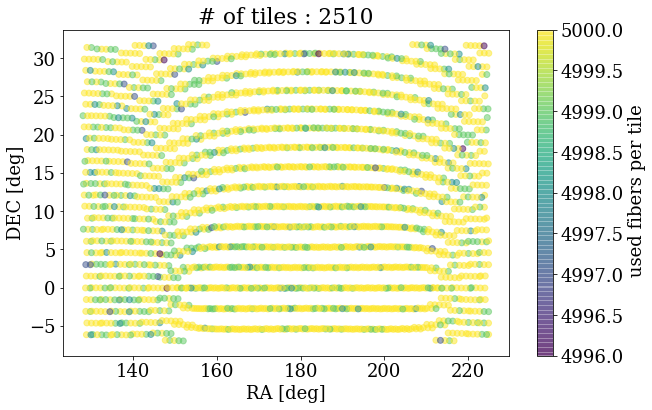

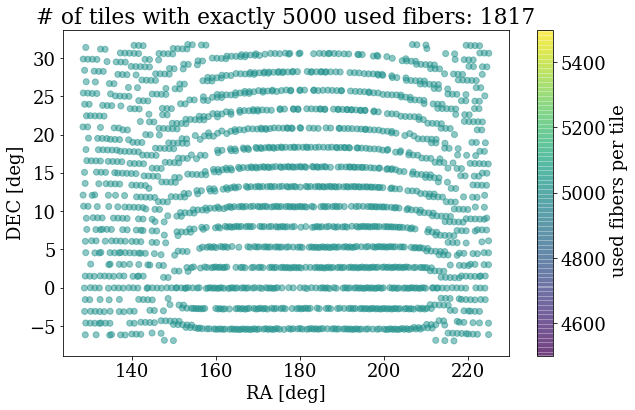

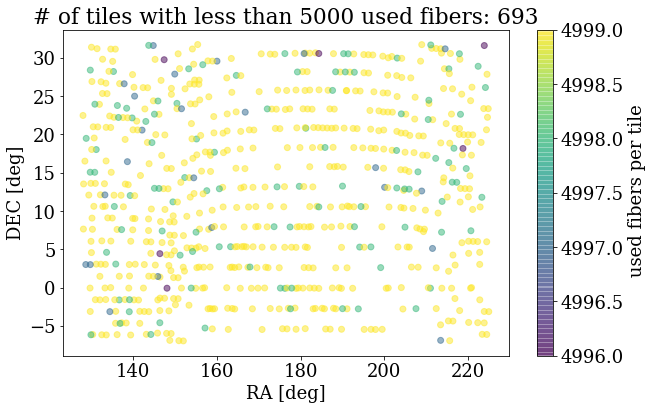

In [21]:
plot_footprint(counts, field='USED', limit=5000, threshold='all')
plot_footprint(counts, field='USED', limit=5000, threshold='exact')
plot_footprint(counts, field='USED', limit=5000, threshold='below')

Plots for the `SKY` fibers:
    
* The number of `SKY` fibers per tile. 
* The tiles where the number of `SKY` fibers is 400.
* The tiles where the humber of `SKY` fibers is below 400.
* The tiles where the humber of `SKY` fibers is above 400.

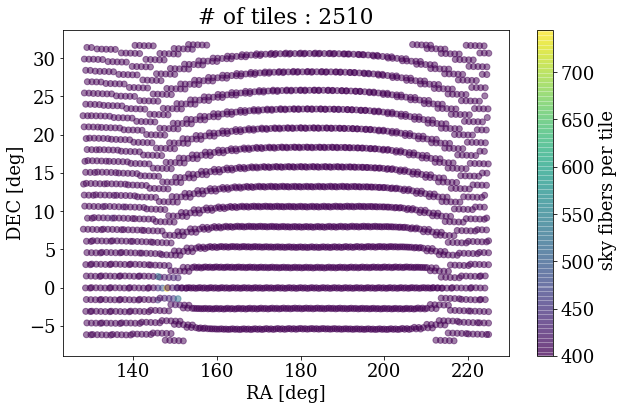

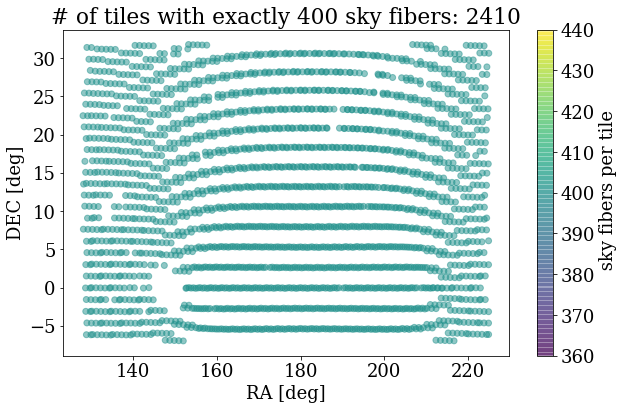

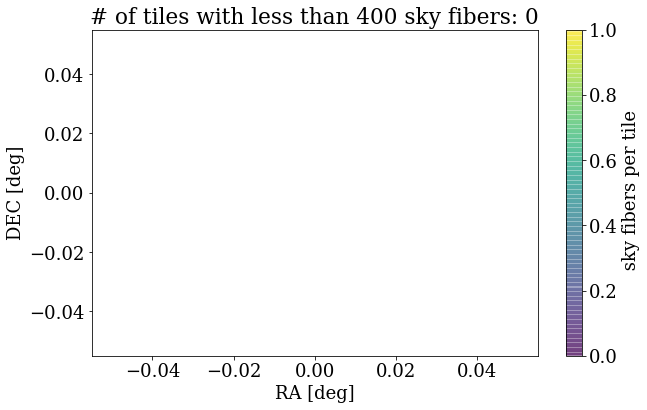

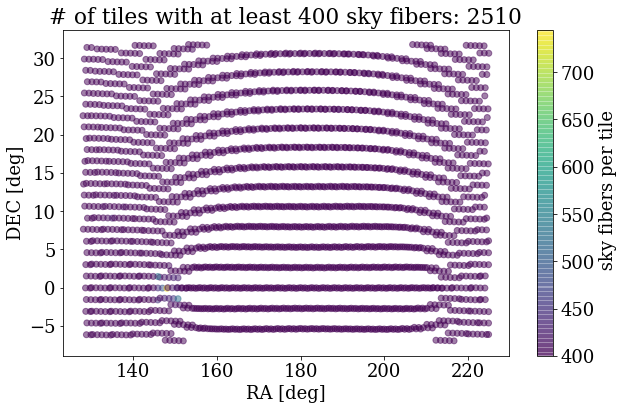

In [22]:
plot_footprint(counts, field='SKY', limit=400, threshold='all')
plot_footprint(counts, field='SKY', limit=400, threshold='exact')
plot_footprint(counts, field='SKY', limit=400, threshold='below')
plot_footprint(counts, field='SKY', limit=400, threshold='above')

Plots for the `STD` fibers:
    
* The number of `STD` fibers per tile. 
* The tiles where the number of `STD` fibers is 100.
* The tiles where the humber of `STD` fibers is below 100.
* The tiles where the humber of `STD` fibers is above 100.

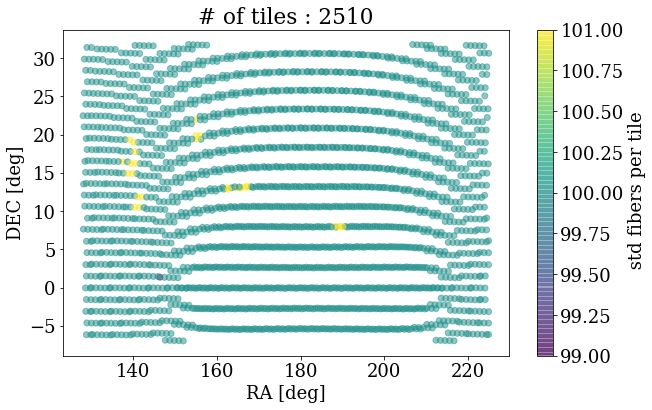

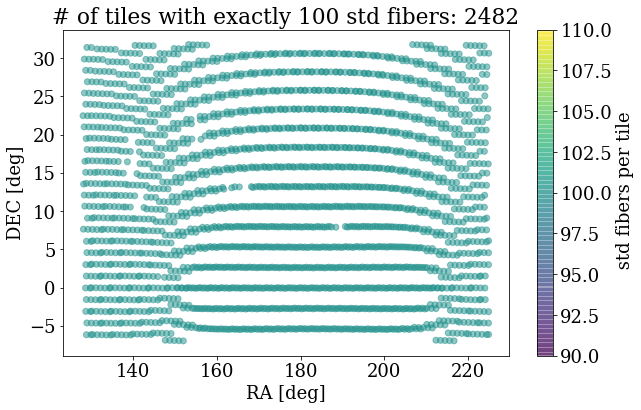

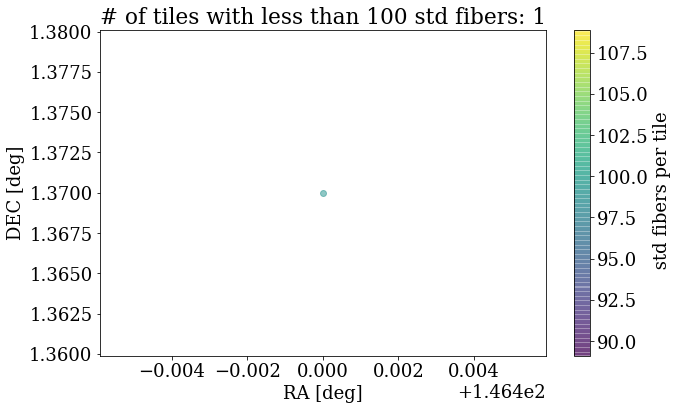

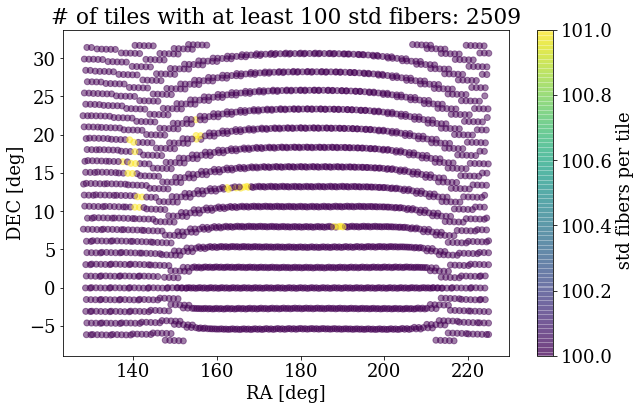

In [23]:
plot_footprint(counts, field='STD', limit=100, threshold='all')
plot_footprint(counts, field='STD', limit=100, threshold='exact')
plot_footprint(counts, field='STD', limit=100, threshold='below')
plot_footprint(counts, field='STD', limit=100, threshold='above')

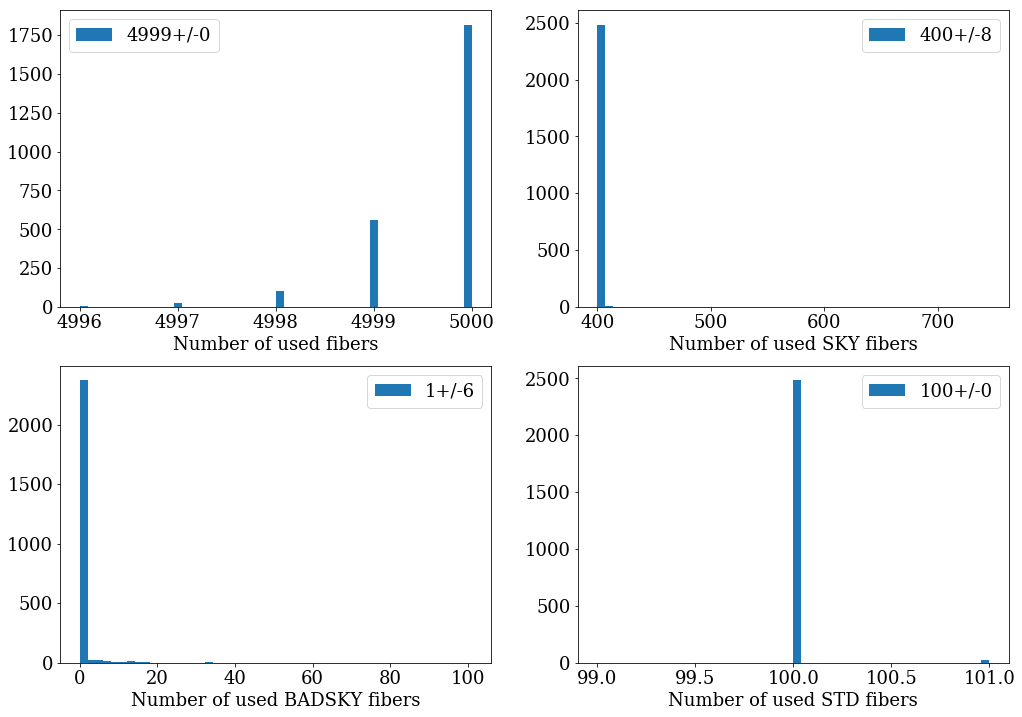

In [24]:
# Distribution of number densities

plt.figure(figsize=(17,12))

plt.subplot(2,2,1)
n = np.int(np.mean(counts['NUSED']))
s = np.int(np.std(counts['NUSED']))
_ = plt.hist(counts['NUSED'], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of used fibers')
plt.legend()


plt.subplot(2,2,2)
n = np.int(np.mean(counts['NSKY']))
s = np.int(np.std(counts['NSKY']))
_ = plt.hist(counts['NSKY'], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of used SKY fibers')
plt.legend()

plt.subplot(2,2,3)
n = np.int(np.mean(counts['NBADSKY']))
s = np.int(np.std(counts['NBADSKY']))
_ = plt.hist(counts['NBADSKY'], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of used BADSKY fibers')
plt.legend()


plt.subplot(2,2,4)
n = np.int(np.mean(counts['NSTD']))
s = np.int(np.std(counts['NSTD']))
_ = plt.hist(counts['NSTD'], bins=50, label='{}+/-{}'.format(n,s))
plt.xlabel('Number of used STD fibers')
plt.legend()

plt.savefig('doc/used_fibers.pdf', bbox_inches='tight')

Not all fibers are used in every tile.

Here we select a couple of tiles that have only `2500` used fibers.

The plots show that for those tiles the focal plane is not fully populated.

For tiles used at the level of '4950' (close to 5000 but not quite)
the problem is that the SKY fibers have low density, making it hard to use as fillers of unused fibers.

This is shown by the figures below:

Below there are of couple of tiles with all the fibers used, 400 for sky and 100 for standards.

In [37]:
ii = (counts['NSKY']>399) & (counts['NSTD']>99)
np.count_nonzero(ii)/len(counts)

0.999601593625498

In [38]:
ii = (counts['NSKY']>399) & (counts['NSTD']>99) & (counts['NUSED']==5000)
np.count_nonzero(ii)/len(counts), np.count_nonzero(ii)

(0.7239043824701196, 1817)

'/global/cscratch1/sd/forero/fiberassign_explore/dark_large/fiber_output/tile_13200.fits'